<a href="https://colab.research.google.com/github/sanjeev29/EVA-4/blob/master/S6/Without_L1_and_L2/without_L1_or_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/S6/Without_L1_and_L2/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/S6/Without_L1_and_L2


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

# Model

In [0]:
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )  # Input: 10x10x16 | Output: 8x8x16 | RF: 14x14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )  # Input: 8x8x16 | Output: 6x6x16 | RF: 18x18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 16, 20, 20]           2,320
             ReLU-14           [-1

# Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
# Save test accuracy and loss to pickle file
import pickle

pickle_file_path = "/content/gdrive/My Drive/Colab Notebooks/S6/Without_L1_and_L2/without_L1_and_L2.pickle"
pickle_obj = {"test_accuracy": test_acc, "test_loss": test_losses}

with open(pickle_file_path, 'wb') as f:
  pickle.dump(pickle_obj, f)
  print("Test accuracy and loss write completed!")

Test accuracy and loss write completed!


# Let's Train and test our model

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
EPOCHS = 40

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1996564120054245 Batch_id=937 Accuracy=92.21: 100%|██████████| 938/938 [00:19<00:00, 56.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 9862/10000 (98.62%)

EPOCH: 1


Loss=0.05265854299068451 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [00:19<00:00, 56.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.04471439868211746 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:18<00:00, 50.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.028665341436862946 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:18<00:00, 51.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.08460656553506851 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:17<00:00, 52.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9922/10000 (99.22%)

EPOCH: 5


Loss=0.013904646039009094 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:17<00:00, 52.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.03722764551639557 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:17<00:00, 52.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.1890464574098587 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:17<00:00, 53.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.017739400267601013 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:17<00:00, 52.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.09010215848684311 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:17<00:00, 52.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.00998590886592865 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:17<00:00, 53.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.027573898434638977 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:17<00:00, 53.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


Loss=0.009413540363311768 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:17<00:00, 53.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.027179524302482605 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:17<00:00, 54.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.0030740946531295776 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:17<00:00, 53.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9947/10000 (99.47%)

EPOCH: 15


Loss=0.01711738109588623 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:17<00:00, 54.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9948/10000 (99.48%)

EPOCH: 16


Loss=0.015961065888404846 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:17<00:00, 54.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


Loss=0.007749520242214203 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:16<00:00, 55.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9951/10000 (99.51%)

EPOCH: 18


Loss=0.05567912012338638 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:17<00:00, 54.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


Loss=0.043037138879299164 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:17<00:00, 53.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9951/10000 (99.51%)

EPOCH: 20


Loss=0.01480904221534729 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:16<00:00, 55.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9949/10000 (99.49%)

EPOCH: 21


Loss=0.014558479189872742 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:17<00:00, 54.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9953/10000 (99.53%)

EPOCH: 22


Loss=0.12652355432510376 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 64.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 23


Loss=0.03925181180238724 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 54.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9950/10000 (99.50%)

EPOCH: 24


Loss=0.007090508937835693 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 60.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9954/10000 (99.54%)

EPOCH: 25


Loss=0.02387295663356781 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 53.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.48%)

EPOCH: 26


Loss=0.14006265997886658 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:17<00:00, 54.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9954/10000 (99.54%)

EPOCH: 27


Loss=0.019965149462223053 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 53.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9954/10000 (99.54%)

EPOCH: 28


Loss=0.18375347554683685 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:17<00:00, 53.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9951/10000 (99.51%)

EPOCH: 29


Loss=0.014267191290855408 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 54.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9952/10000 (99.52%)

EPOCH: 30


Loss=0.027761220932006836 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:17<00:00, 54.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9951/10000 (99.51%)

EPOCH: 31


Loss=0.14536400139331818 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:17<00:00, 53.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9952/10000 (99.52%)

EPOCH: 32


Loss=0.028458476066589355 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 54.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9951/10000 (99.51%)

EPOCH: 33


Loss=0.07408016920089722 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 54.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9955/10000 (99.55%)

EPOCH: 34


Loss=0.04287683963775635 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:16<00:00, 56.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9946/10000 (99.46%)

EPOCH: 35


Loss=0.0052561163902282715 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:16<00:00, 55.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9952/10000 (99.52%)

EPOCH: 36


Loss=0.0202287957072258 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:16<00:00, 55.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99.49%)

EPOCH: 37


Loss=0.035070180892944336 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:16<00:00, 55.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9953/10000 (99.53%)

EPOCH: 38


Loss=0.03436249494552612 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:16<00:00, 63.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9950/10000 (99.50%)

EPOCH: 39


Loss=0.03618776053190231 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:16<00:00, 56.35it/s]



Test set: Average loss: 0.0177, Accuracy: 9953/10000 (99.53%)



# Result Visualization

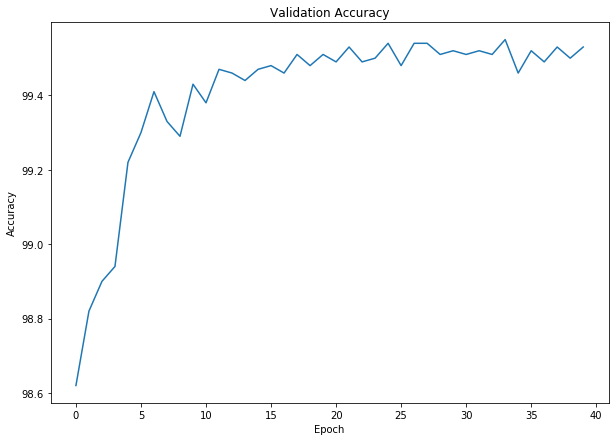

In [11]:
import matplotlib.pyplot as plt

val_acc_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test accuracy plot
axs.plot(test_acc)
axs.set_title("Validation Accuracy")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
val_acc_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/Without_L1_and_L2/validation_accuracy_change_plot.jpg')

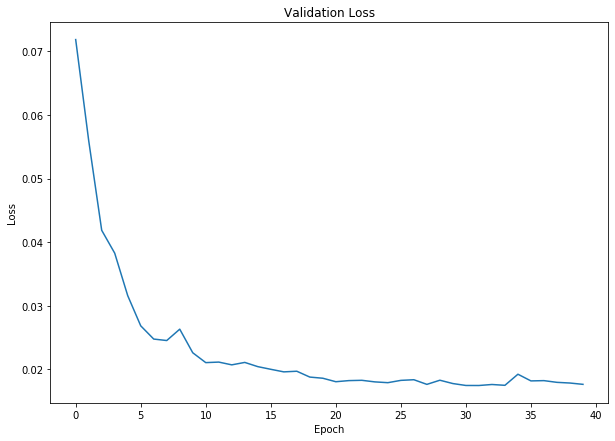

In [12]:
val_loss_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test loss plot
axs.plot(test_losses)
axs.set_title("Validation Loss")
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
val_loss_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/Without_L1_and_L2/validation_loss_change_plot.jpg')

# Misclassified Images

In [0]:
import numpy as np

from google.colab import files

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count == 25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig("/content/gdrive/My Drive/Colab Notebooks/S6/Without_L1_and_L2/misclassified_images/image_" + str(count)+".jpg")
                plt.close(fig)
                count += 1